## Deep Learning Course Project - Gesture Recognition

Developed by : Ritwik Raj and Ritesh Kumar 

### Problem Statement 

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Gesture	Corresponding Action
- Thumbs Up : Increase the volume.
- Thumbs Down :	Decrease the volume.
- Left Swipe  :	'Jump' backwards 10 seconds.
- Right Swipe : 'Jump' forward 10 seconds.
- Stop : Pause the movie.

Each video is a sequence of 30 frames (or images).

### Objective 

1. Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. Model: Develop a model that is able to train without any errors which will be 3. judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
# libraries 

import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.transform import resize
import datetime
import os

In [ ]:
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
tf.random.set_seed(30)

In [ ]:
# Mount data 

if 'google.colab' in str(get_ipython()):
    root_path = '/content/gdrive/MyDrive/Project_data/Project_data/'
else:
    root_path = 'datasets/Project_data/'

train_doc = np.random.permutation(open(root_path + 'train.csv').readlines())
val_doc = np.random.permutation(open(root_path + 'val.csv').readlines())
batch_size = 10 # We'll further experiment with the batch size 

* Read the folder names for training and validation 
* Set the batch size (keep increasing the batch size until the machine throws an error)

In [4]:
def count_images(folder_path):
    total_images = 0
    for root, dirs, files in os.walk(folder_path):
        total_images += len([file for file in files if file.lower().endswith(('jpg', 'jpeg', 'png'))])
    return total_images

train_image_count = count_images(root_path + 'train')
val_image_count = count_images(root_path + 'val')

print(f"Total images in train folder: {train_image_count}")
print(f"Total images in val folder: {val_image_count}")

Total images in train folder: 19890
Total images in val folder: 3000


####  Cropping function for Generator 

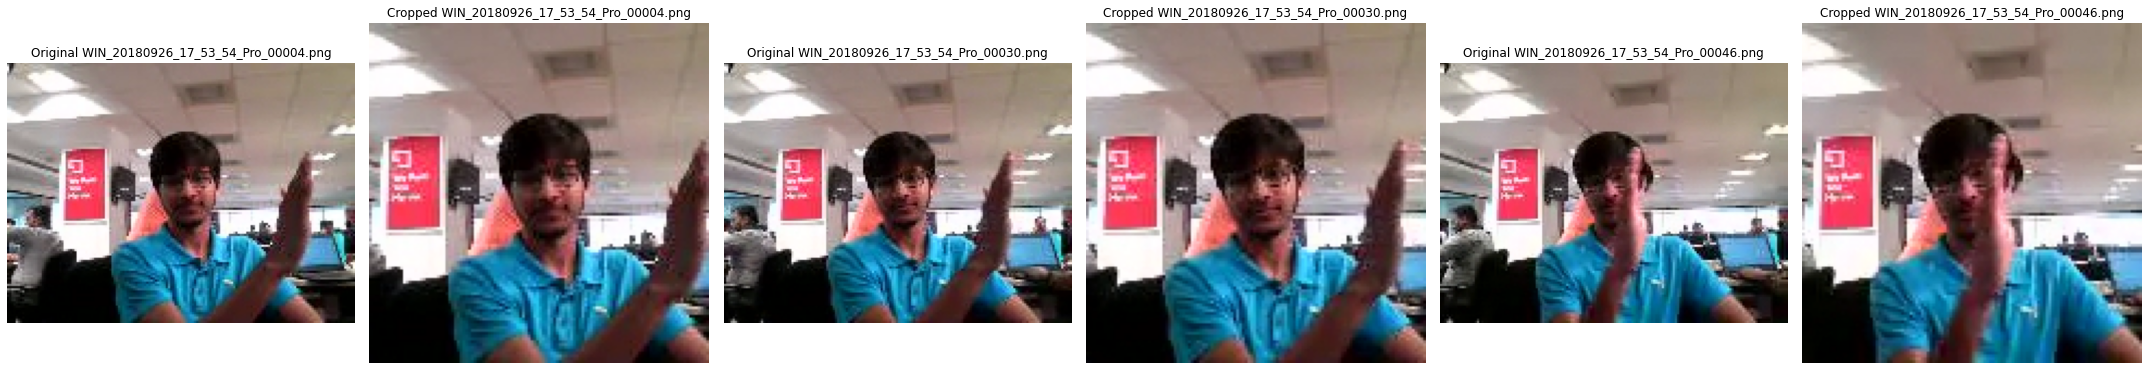

In [ ]:
def square_crop(image_array):
    # Get the dimensions of the image
    height, width = image_array.shape[:2]

    # Calculate the size of the square (the smaller dimension)
    new_size = min(width, height)

    # Calculate the cropping box (centered)
    left = (width - new_size) // 2
    top = (height - new_size) // 2
    right = (width + new_size) // 2
    bottom = (height + new_size) // 2

    # Crop the image to the square using NumPy array slicing
    cropped_image = image_array[top:bottom, left:right]

    return cropped_image

sample_images_dir = root_path + 'train/WIN_20180926_17_53_54_Pro_Right_Swipe_new'

# Get a list of all .png image files in the directory
image_files = [f for f in os.listdir(sample_images_dir) if f.endswith('.png')]

# Select the first, middle, and last images
num_images = len(image_files)
first_image = image_files[0]
middle_image = image_files[num_images // 2]
last_image = image_files[-1]

# Create a plot to display the images
plt.figure(figsize=(30, 10))

# List of selected image files (first, middle, last)
selected_images = [first_image, middle_image, last_image]

# Loop through and display each selected image
for idx, image_name in enumerate(selected_images):
    # Load the image using skimage
    image_path = os.path.join(sample_images_dir, image_name)
    image = imread(image_path)  # Reads the image as a NumPy array

    # Apply the square_crop function
    cropped_image = square_crop(image)

    # Plot the original and cropped image side by side (2 subplots per image)
    plt.subplot(2, 6, 2*idx + 1)
    plt.imshow(image)
    plt.title(f"Original {image_name}")
    plt.axis('off')

    plt.subplot(2, 6, 2*idx + 2)
    plt.imshow(cropped_image)
    plt.title(f"Cropped {image_name}")
    plt.axis('off')

# Tight layout for better fitting
plt.tight_layout()

# Show the plot
plt.show()

Cropped images retains the nature of the gesture. 

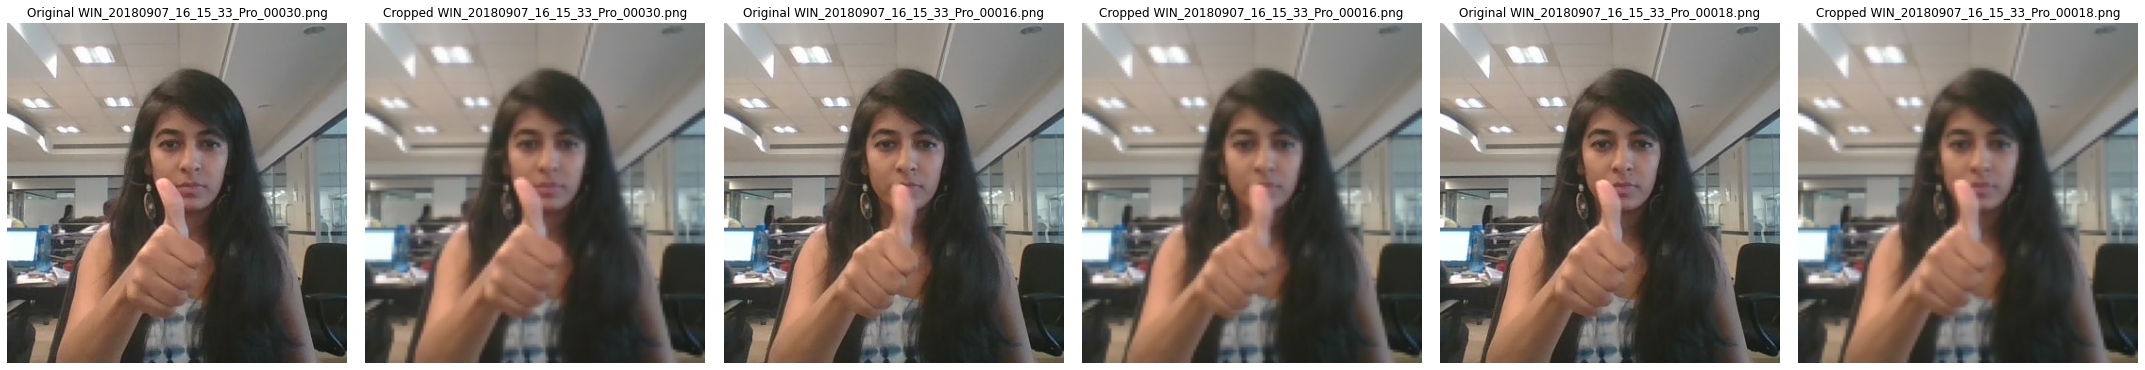

In [6]:
sample_images_dir = root_path + 'train/WIN_20180907_16_15_33_Pro_Thumbs Up_new'

# Get a list of all .png image files in the directory
image_files = [f for f in os.listdir(sample_images_dir) if f.endswith('.png')]

# Select the first, middle, and last images
num_images = len(image_files)
first_image = image_files[0]
middle_image = image_files[num_images // 2]
last_image = image_files[-1]

# Create a plot to display the images
plt.figure(figsize=(30, 10))

# List of selected image files (first, middle, last)
selected_images = [first_image, middle_image, last_image]

# Loop through and display each selected image
for idx, image_name in enumerate(selected_images):
    # Load the image using skimage
    image_path = os.path.join(sample_images_dir, image_name)
    image = imread(image_path)  # Reads the image as a NumPy array

    # Apply the resize function
    resized_image = resize(image, (128, 128))

    # Plot the original and cropped image side by side (2 subplots per image)
    plt.subplot(2, 6, 2*idx + 1)
    plt.imshow(image)
    plt.title(f"Original {image_name}")
    plt.axis('off')

    plt.subplot(2, 6, 2*idx + 2)
    plt.imshow(resized_image)
    plt.title(f"Cropped {image_name}")
    plt.axis('off')

# Tight layout for better fitting
plt.tight_layout()

# Show the plot
plt.show()

### Generator 

One of the more important parts of the code. 

In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 

We have to experiment with 'img_idx', 'y', 'z' and normalization such that you get high accuracy. 

In [7]:
def generator(source_path, folder_list, batch_size, factor=1, img_size=128):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [k for k in range(0, 30, factor)]  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = img_size
    z = img_size

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes

                    # video images have two types of dimensions - either 360x360 or 120x160
                    # we must crop the images to 1:1 aspect ration and resize them to 120x120 dimensions or the specified dimensions

                    if image.shape[0] == 120:
                        # Image Crop
                        image = square_crop(image)

                    if image.shape[0] != img_size:
                        # Image Resize
                        image = resize(image, (img_size, img_size))


                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 # normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        remaining_data = len(t)%batch_size
        if (remaining_data) != 0:
            batch_data = np.zeros((remaining_data,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_data,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_data): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes

                    # video images have two types of dimensions - either 360x360 or 120x160
                    # we must crop the images to 1:1 aspect ration and resize them to 120x120 dimensions or the specified dimensions

                    if image.shape[0] == 120:
                        # Image Crop
                        image = square_crop(image)

                    if image.shape[0] != img_size:
                        # Image Resize
                        image = resize(image, (img_size, img_size))


                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 # normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = root_path + 'train'
val_path = root_path + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 18 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 18


### Model No. 1 - Conv3D - 3 Convolutional Layers 

- Model Type: Design a 3D Convolutional Neural Network (CNN) model.
- Convolutional Layers: Utilize Conv3D layers for 3D convolution.
- Pooling Layers: Employ MaxPooling3D layers for max pooling.
- Alternative Architecture: For a Conv2D + RNN model, ensure the use of TimeDistributed to wrap the Conv2D layers.
- Output Layer: The final layer of the model must be a softmax activation function.
- Optimization Goal: Design the network architecture to achieve good accuracy with the least number of parameters.
- Memory Constraint: The model should be lightweight enough to fit within the memory limitations of a webcam.

In [10]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Dense, LSTM, GRU
from keras.layers import Flatten, Dropout, TimeDistributed, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, Input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [12]:
# Building the model 

img_size = 128
input_shape = (30, img_size, img_size, 3)
num_classes = 5

#write your model here

model1 = Sequential()

# Use the Input layer to define the input shape
model1.add(Input(shape=input_shape))

# First 3D Convolutional layer
model1.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second 3D Convolutional layer
model1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional layer
model1.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the 3D output for Dense layers
model1.add(Flatten())

# Fully connected (Dense) layers
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model1.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 32, 32, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 7, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 3, 16, 16, 64)   

### Compiling the model 

After compiling the model, print the summary of the model which will show us the total number of parameters you have to train

In [18]:
optimiser = Adam(learning_rate=0.001) # write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Create the generators 

# Will be creating the train_generator and the val_generator which will be used in .fit_generator
train_generator = generator(train_path, train_doc, batch_size, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, img_size=img_size)

# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)

# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  datasets/Project_data/train ; batch size = 10
Source path =  datasets/Project_data/val ; batch size = 10
Train batch shape: (10, 30, 128, 128, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 30, 128, 128, 3)
Validation labels shape: (10, 5)


In [20]:
# Set up callbacks 

if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-1-conv3d-3-layers'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

### Train the model 

In [17]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history1 = model1.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40


2025-04-09 04:40:38.473530: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.6502 - categorical_accuracy: 0.2413
Epoch 00001: saving model to output_folder/model-1-conv3d-3-layers_2025-04-0904_37_58.982311/model-00001-1.65021-0.24133-1.60759-0.22000.keras
67/67 [==============================] - 226s 3s/step - loss: 1.6502 - categorical_accuracy: 0.2413 - val_loss: 1.6076 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/40
67/67 [==============================] - ETA: 0s - loss: 1.5566 - categorical_accuracy: 0.2805
Epoch 00002: saving model to output_folder/model-1-conv3d-3-layers_2025-04-0904_37_58.982311/model-00002-1.55655-0.28054-1.47138-0.49000.keras
67/67 [==============================] - 228s 3s/step - loss: 1.5566 - categorical_accuracy: 0.2805 - val_loss: 1.4714 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 3/40
67/67 [==============================] - ETA: 0s - loss: 1.3948 - categorical_accuracy: 0.3846
Epoch 00003: saving model to output_folder/model-1-conv3d-3-layers_2025-0

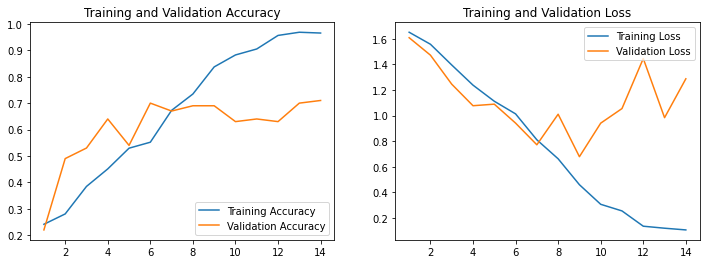

In [ ]:
# Visualising Training Results 

accuracy = history1.history['categorical_accuracy']
val_accuracy = history1.history['val_categorical_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(1, len(history1.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Model No. 2 - Conv3D - 4 Convolutional Layers 

Adding a Convolutional layer will :

* Deeper Feature Hierarchy: A fourth Conv3D layer enables learning more abstract and complex features by combining high-level features from earlier layers, potentially capturing subtle spatio-temporal patterns.

* More Parameters: Adding a layer increases trainable parameters, leading to slower training and a larger memory footprint.

* Overfitting Risk: Deeper networks are more susceptible to overfitting, especially with limited data, necessitating stronger regularization.

* Richer Feature Space: The model develops a higher-dimensional, semantically richer representation, beneficial for discerning fine-grained details in complex data.

* Potential Accuracy Gain: For intricate tasks, the increased depth can lead to higher accuracy by learning more discriminative features compared to shallower models.

In [13]:
# Build the Model

model2 = Sequential()

# Use the Input layer to define the input shape
model2.add(Input(shape=input_shape))

# First 3D Convolutional layer
model2.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second 3D Convolutional layer
model2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional layer
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth 3D Convolutional layer
model2.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# GlobalAveragePooling the 3D output for Dense layers
model2.add(GlobalAveragePooling3D())

# Fully connected (Dense) layers
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model2.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 128, 128, 16)  1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 64, 64, 16)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 32, 32, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 7, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 3, 16, 16, 64)   

In [14]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [15]:
# Set up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-2-conv3d-4-layers'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [16]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
# Train the model
history2 = model2.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/18


2025-04-09 07:40:46.780001: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5991 - categorical_accuracy: 0.2428
Epoch 00001: saving model to output_folder/model-1-conv3d-3-layers_2025-04-0907_39_14.441501/model-00001-1.59913-0.24284-1.48376-0.43000.keras
67/67 [==============================] - 188s 3s/step - loss: 1.5991 - categorical_accuracy: 0.2428 - val_loss: 1.4838 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 2/18
67/67 [==============================] - ETA: 0s - loss: 1.4770 - categorical_accuracy: 0.3228
Epoch 00002: saving model to output_folder/model-1-conv3d-3-layers_2025-04-0907_39_14.441501/model-00002-1.47697-0.32278-1.49328-0.35000.keras
67/67 [==============================] - 158s 2s/step - loss: 1.4770 - categorical_accuracy: 0.3228 - val_loss: 1.4933 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/18
67/67 [==============================] - ETA: 0s - loss: 1.4103 - categorical_accuracy: 0.3409
Epoch 00003: saving model to output_folder/model-1-conv3d-3-layers_2025-0

Text(0.5, 1.0, 'Training and Validation Loss')

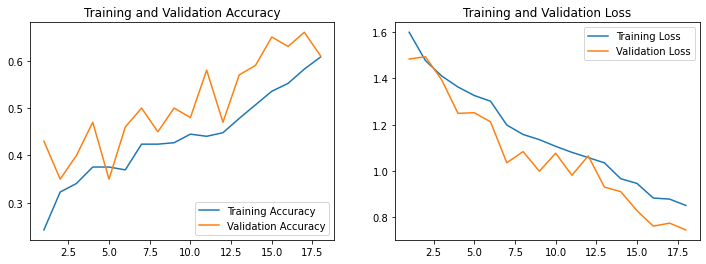

In [28]:
# Visualize the training results
accuracy = history2.history['categorical_accuracy']
val_accuracy = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1, len(history2.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

### Model No. 3 - Conv3D - 6 Convolutional layers 

* Even Deeper Features: Learns highly abstract, complex spatio-temporal patterns.

* Significantly More Parameters: Increases training time, memory usage, and overfitting risk substantially.

* Richer Representation: Creates a very high-dimensional feature space.
Potential for Higher Accuracy (very complex tasks): May yield better results on extremely intricate datasets, but harder to train.

In [29]:
# Build the Model

model3 = Sequential()

# Use the Input layer to define the input shape
model3.add(Input(shape=input_shape))

# First Block
model3.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Block
model3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Block
model3.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.25))

# Fourth Block
model3.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.25))

# Flatten the 3D output for Dense layers
model3.add(Flatten())

# Fully connected (Dense) layers
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model3.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 30, 128, 128, 16)  1312      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 15, 64, 64, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 15, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 32, 32, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_15 (Conv3D)          (None, 7, 32, 32, 64)     55360     
                                                                 
 conv3d_16 (Conv3D)          (None, 7, 32, 32, 64)    

In [30]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
# Set up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-3-conv3d-6-layers'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [32]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
# Train the model
history3 = model3.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/18
67/67 [==============================] - ETA: 0s - loss: 1.6145 - categorical_accuracy: 0.1659
Epoch 00001: saving model to output_folder/model-3-conv3d-6-layers_2025-04-0907_39_14.441501/model-00001-1.61446-0.16591-1.60842-0.15000.keras
67/67 [==============================] - 157s 2s/step - loss: 1.6145 - categorical_accuracy: 0.1659 - val_loss: 1.6084 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/18
67/67 [==============================] - ETA: 0s - loss: 1.6099 - categorical_accuracy: 0.1916
Epoch 00002: saving model to output_folder/model-3-conv3d-6-layers_2025-04-0907_39_14.441501/model-00002-1.60987-0.19155-1.60775-0.21000.keras
67/67 [==============================] - 155s 2s/step - loss: 1.6099 - categorical_accuracy: 0.1916 - val_loss: 1.6077 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/18
67/67 [==============================] - ETA: 0s - loss: 1.6098 - categorical_accuracy: 0.2021
Epoch 00003: saving model to output_folder/model-3-conv3d-6-la

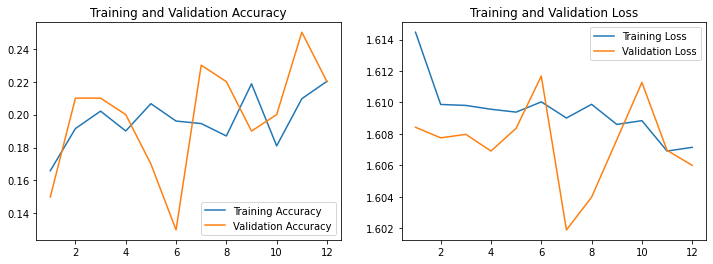

In [ ]:
# Visualize the training results
accuracy = history3.history['categorical_accuracy']
val_accuracy = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(1, len(history3.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Model No. 4 - Conv3D - 4 Convolutional layers (wider)

Differences between Wider 4 Convolutional layer and Deeper 6 convolutional layer 

* Wider (4): More parallel features, faster per layer, higher memory per layer, complex local patterns.

* Deeper (6): More hierarchical features, better long-range, risk of gradients, potentially slower but smaller layers possible.

In [ ]:
model4 = Sequential()

# Use the Input layer to define the input shape
model4.add(Input(shape=input_shape))

# First 3D Convolutional layer
model4.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second 3D Convolutional layer
model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional layer
model4.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth 3D Convolutional layer
model4.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# GlobalAveragePooling the 3D output for Dense layers
model4.add(GlobalAveragePooling3D())

# Fully connected (Dense) layers
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model4.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 30, 128, 128, 32)  2624      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 15, 64, 64, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 15, 64, 64, 64)    55360     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 7, 32, 32, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 7, 32, 32, 128)    221312    
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 3, 16, 16, 128)  

In [ ]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Set up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-4-conv3d-4-layers-wider'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [ ]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
# Train the model
history4 = model4.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/18
67/67 [==============================] - ETA: 0s - loss: 1.6104 - categorical_accuracy: 0.2036
Epoch 00001: saving model to output_folder/model-4-conv3d-4-layers-wider_2025-04-0907_39_14.441501/model-00001-1.61042-0.20362-1.57757-0.44000.keras
67/67 [==============================] - 153s 2s/step - loss: 1.6104 - categorical_accuracy: 0.2036 - val_loss: 1.5776 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/18
67/67 [==============================] - ETA: 0s - loss: 1.4962 - categorical_accuracy: 0.3469
Epoch 00002: saving model to output_folder/model-4-conv3d-4-layers-wider_2025-04-0907_39_14.441501/model-00002-1.49622-0.34691-1.40671-0.38000.keras
67/67 [==============================] - 153s 2s/step - loss: 1.4962 - categorical_accuracy: 0.3469 - val_loss: 1.4067 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 3/18
67/67 [==============================] - ETA: 0s - loss: 1.3798 - categorical_accuracy: 0.3771
Epoch 00003: saving model to output_folder/model-4

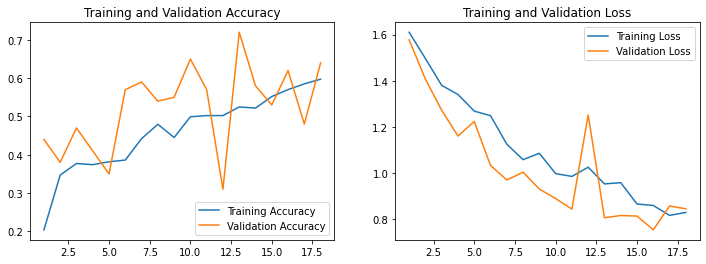

In [ ]:
# Visualize the training results
accuracy = history4.history['categorical_accuracy']
val_accuracy = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(1, len(history4.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Model No. 5 - EfficientNetBO (Image Net) + LSTM

* EfficientNetBO (ImageNet) + LSTM:

    * Leverages a pre-trained, efficient feature extractor (EfficientNetBO on ImageNet).

    * LSTM adds temporal modeling for sequential data.

    * Potentially high accuracy and efficiency due to EfficientNet's design.

    * Fewer parameters than very deep ConvNets.

In [ ]:
img_size = 64

## CHANGING THE NUMBER OF EPOCHS
num_epochs = 40 

input_shape = (30, img_size, img_size, 3)
num_classes = 5

train_generator = generator(train_path, train_doc, batch_size, factor=2, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, factor=2, img_size=img_size)

# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)

# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  datasets/Project_data/train ; batch size = 10
Source path =  datasets/Project_data/val ; batch size = 10
Train batch shape: (10, 15, 64, 64, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 15, 64, 64, 3)
Validation labels shape: (10, 5)


In [ ]:
# Download EfficientNetB0 architecture pre-trained on ImageNet
from tensorflow.keras.applications import EfficientNetB0

base_model_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model_effnet.trainable = True

# write your model here

model5 = Sequential()

# Use the Input layer to define the input shape
model5.add(Input(shape=input_shape))

# TimeDistributed wrapper for EfficientNetB0
model5.add(TimeDistributed(base_model_effnet))

# Global Average Pooling layer to reduce dimensions
model5.add(TimeDistributed(GlobalAveragePooling2D()))

# LSTM layer to capture temporal dependencies
model5.add(LSTM(128, return_sequences=False))

# Fully connected layers
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model5.add(Dense(num_classes, activation='softmax'))

model5.summary()

16719872/16705208 [==============================] - 2s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 2, 2, 1280)   4049571   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1280)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               721408    
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                       

In [ ]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Set Up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-5-efficientnetb0-lstm'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Train the model
history5 = model5.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.4014 - loss: 1.4081
Epoch 1: saving model to output_folder/model-5-efficientnetb0-lstm_2024-12-3106_57_11.181674/model-00001-1.16322-0.53846-1.94728-0.20000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1046s 9s/step - categorical_accuracy: 0.4034 - loss: 1.4045 - val_categorical_accuracy: 0.2000 - val_loss: 1.9473 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.7823 - loss: 0.6852
Epoch 2: saving model to output_folder/model-5-efficientnetb0-lstm_2024-12-3106_57_11.181674/model-00002-0.66631-0.77828-3.19144-0.22000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 636s 10s/step - categorical_accuracy: 0.7822 - loss: 0.6849 - val_categorical_accuracy: 0.2200 - val_loss: 3.1914 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.7618 - loss: 0.7623
Epoch 3: saving model to output_folder/model-5-efficientnetb0-lstm_2024-12-3106_57_11.181674/model-

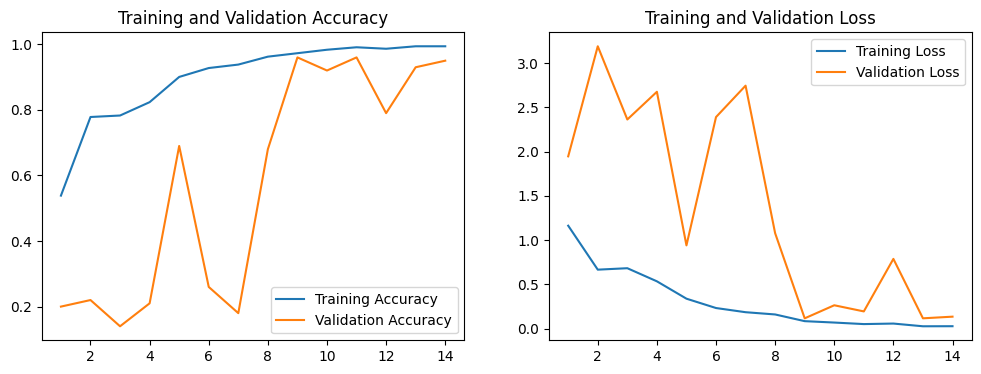

In [ ]:
# Visualize the training results
accuracy = history5.history['categorical_accuracy']
val_accuracy = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(1, len(history5.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Model No. 6 - MobileNetV2 (Image Net) + LSTM

* MobileNetV2 + LSTM: Lightweight, efficient feature extractor. Faster inference, smaller model size. Potentially lower accuracy than EfficientNetBO on complex tasks.

* EfficientNetBO + LSTM: More complex, higher capacity feature extractor. Potentially higher accuracy but larger model and slower inference than MobileNetV2.

Both leverage pre-trained ImageNet weights for better generalization. LSTM adds temporal processing for sequences.

In [ ]:
img_size = 96
input_shape = (30, img_size, img_size, 3)
num_classes = 5

train_generator = generator(train_path, train_doc, batch_size, factor=2, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, factor=2, img_size=img_size)

# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)


# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  Project_data/Project_data/train ; batch size = 10
Source path =  Project_data/Project_data/val ; batch size = 10
Train batch shape: (10, 15, 96, 96, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 15, 96, 96, 3)
Validation labels shape: (10, 5)


In [ ]:
# Download MobileNet architecture pre-trained on ImageNet
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model_mobilenet.trainable = True

# write your model here

model6 = Sequential()

# Use the Input layer to define the input shape
model6.add(Input(shape=input_shape))

# TimeDistributed wrapper for MobileNetV2
model6.add(TimeDistributed(base_model_mobilenet))

# Global Average Pooling layer to reduce dimensions
model6.add(TimeDistributed(GlobalAveragePooling2D()))

# LSTM layer to capture temporal dependencies
model6.add(LSTM(128, return_sequences=False))

# Fully connected layers
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model6.add(Dense(num_classes, activation='softmax'))

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 30, 3, 3, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,549 (11.43 MB)

 Trainable params: 2,962,437 (11.30 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Set Up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-6-mobilenetv2-lstm'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

# Train the model
history6 = model6.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.4617 - loss: 1.3070 
Epoch 1: saving model to output_folder/model-6-mobilenetv2-lstm_2024-12-3106_57_11.181674/model-00001-1.06627-0.60784-1.58440-0.43000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1490s 18s/step - categorical_accuracy: 0.4639 - loss: 1.3035 - val_categorical_accuracy: 0.4300 - val_loss: 1.5844 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.7787 - loss: 0.6736 
Epoch 2: saving model to output_folder/model-6-mobilenetv2-lstm_2024-12-3106_57_11.181674/model-00002-0.70816-0.76471-1.78441-0.44000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1044s 16s/step - categorical_accuracy: 0.7785 - loss: 0.6741 - val_categorical_accuracy: 0.4400 - val_loss: 1.7844 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.8040 - loss: 0.6672 
Epoch 3: saving model to output_folder/model-6-mobilenetv2-lstm_2024-12-3106_57_11.181674/model-0

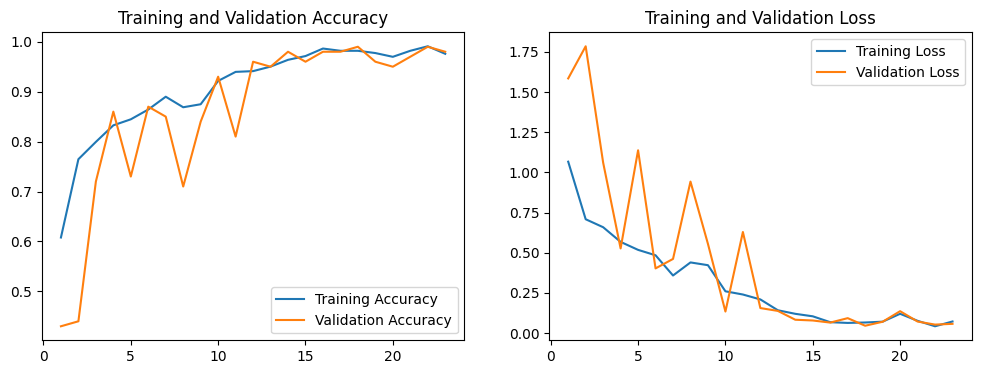

In [ ]:
# Visualize the training results
accuracy = history6.history['categorical_accuracy']
val_accuracy = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(1, len(history6.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Model No. 7 - MobileNetV2(Image Net) + GRU 

* GRU: Gated Recurrent Unit. Simpler architecture than LSTM, potentially faster training and inference with slightly fewer parameters. May capture short-term dependencies effectively.

* LSTM: Long Short-Term Memory. More complex, better at capturing long-range dependencies due to its cell state. Might achieve higher accuracy on tasks requiring memory over longer sequences.

* Both use MobileNetV2 (ImageNet) for efficient feature extraction. The main difference lies in their recurrent layer's ability to model temporal sequences.

In [ ]:
img_size = 96
input_shape = (30, img_size, img_size, 3)
num_classes = 5

train_generator = generator(train_path, train_doc, batch_size, factor=2, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, factor=2, img_size=img_size)

# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)

# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  Project_data/Project_data/train ; batch size = 10
Source path =  Project_data/Project_data/val ; batch size = 10
Train batch shape: (10, 15, 96, 96, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 15, 96, 96, 3)
Validation labels shape: (10, 5)


In [ ]:
# Download MobileNet architecture pre-trained on ImageNet
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model_mobilenet.trainable = True

# write your model here

model7 = Sequential()

# Use the Input layer to define the input shape
model7.add(Input(shape=input_shape))

# TimeDistributed wrapper for MobileNetV2
model7.add(TimeDistributed(base_model_mobilenet))

# Global Average Pooling layer to reduce dimensions
model7.add(TimeDistributed(GlobalAveragePooling2D()))

# GRU layer to capture temporal dependencies
model7.add(GRU(128, return_sequences=False))

# Fully connected layers
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model7.add(Dense(num_classes, activation='softmax'))

model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 3, 3, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       541,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,816,581 (10.74 MB)

 Trainable params: 2,782,469 (10.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Train the model
history7 = model7.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4463 - loss: 1.3405
Epoch 1: saving model to output_folder/model-7-mobilenet-gru_2025-01-0106_42_10.589879/model-00001-1.01607-0.60935-1.13243-0.58000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 745s 7s/step - categorical_accuracy: 0.4487 - loss: 1.3357 - val_categorical_accuracy: 0.5800 - val_loss: 1.1324 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.7827 - loss: 0.7323
Epoch 2: saving model to output_folder/model-7-mobilenet-gru_2025-01-0106_42_10.589879/model-00002-0.72244-0.77074-0.93268-0.73000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 528s 8s/step - categorical_accuracy: 0.7825 - loss: 0.7321 - val_categorical_accuracy: 0.7300 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.8612 - loss: 0.4605
Epoch 3: saving model to output_folder/model-7-mobilenet-gru_2025-01-0106_42_10.589879/model-00003-0.50342-0.8552

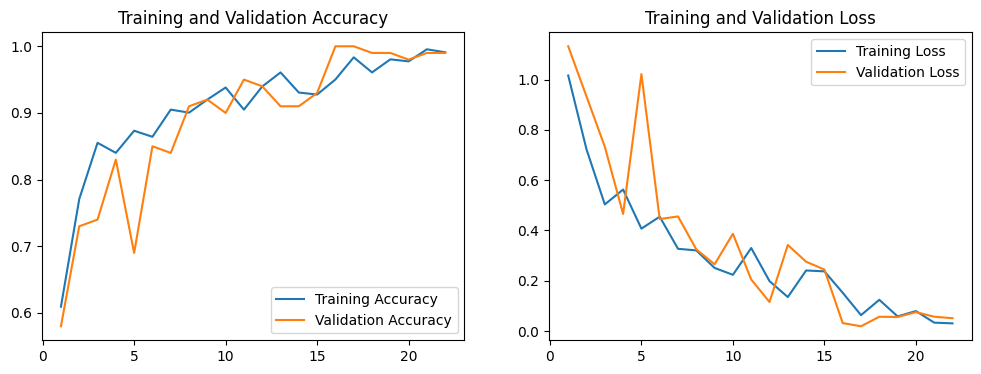

In [ ]:
# Visualize the training results
accuracy = history7.history['categorical_accuracy']
val_accuracy = history7.history['val_categorical_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(1, len(history7.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Conclusion 

- Model: Hand gesture recognition system using MobileNet + GRU.

- Performance: Achieved 99.37% training accuracy and 98% validation accuracy.

- Significance: Demonstrates strong performance and generalization for touchless human-computer interaction.

- Application: Significant step towards natural interaction for Smart TVs.

- Benefits: Enhances user convenience, accessibility, and interaction experience.

- Approach: Combines lightweight deep learning (MobileNet) with sequential modeling (GRU).

- Potential: Showcases the potential for cost-effective, scalable smart home solutions.

- Foundation: Leverages accessible hardware and open-source tools.

- Future: Further refinement and integration could make such systems standard in smart living environments.
